# Gridded Data: Remote access of satellite data from NOAA CoastWatch ERDDAP
Demonstrate query and access of data from [NOAA CoastWatch ERDDAP](https://coastwatch.pfeg.noaa.gov/erddap/), again using `xarray` with the `OPeNDATA` remote access protocol to download the desired subsets of data, and `xarray` to explore the data.

- [Emilio Mayorga](https://github.com/emiliom/), University of Washington and NANOOS/IOOS

[OceanHackWeek 2019](https://oceanhackweek.github.io/)

-------------------

# Import packages

In [1]:
import warnings
warnings.simplefilter('ignore') # filter some warning messages

import datetime
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
BASEPATH = Path('.')

# NOAA CoastWatch ERDDAP request for Chlorophyll from the VIIRS satellite sensor

- **First, we'll go to the NOAA CoastWatch ERDDAP and explore remote sensing datasets for chlorophyll:** https://coastwatch.pfeg.noaa.gov/erddap/
- The query we'll compose can be specified as this url: https://coastwatch.pfeg.noaa.gov/erddap/search/index.html?searchFor=viirs+chlorophyll+-DEPRECATED+-EXPERIMENTAL
- Once we identify the dataset we're interested, we'll copy the URL here to read it via **OPeNDAP**.

In [4]:
erddap_opendap_url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/pmlEsaCCI31OceanColor8Day'

In [5]:
ds = xr.open_dataset(erddap_opendap_url)

In [6]:
ds

<xarray.Dataset>
Dimensions:             (latitude: 4320, longitude: 8640, time: 959)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2018-06-26
  * latitude            (latitude) float32 89.979164 89.9375 ... -89.979164
  * longitude           (longitude) float32 -179.97917 -179.9375 ... 179.97917
Data variables:
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_443             (time, latitude, longitude) float32 ...
    Rrs_490             (time, latitude, longitude) float32 ...
    Rrs_510             (time, latitude, longitude) float32 ...
    Rrs_555             (time, latitude, longitude) float32 ...
    Rrs_670             (time, latitude, longitude) float32 ...
    water_class1        (time, latitude, longitude) float32 ...
    water_class2        (time, latitude, longitude) float32 ...
    water_class3        (time, latitude, longitude) float32 ...
    water_class4        (time, latitude, longitude) float32 ...
    water_class5  

Is latitude reversed?? If so, is that an issue? ERDDAP plots it just fine, but I'm getting zero values in the xarray subset request
```
Dimensions:             (latitude: 4320, longitude: 8640, time: 959)
Coordinates:
  * time                (time) datetime64[ns] 1997-09-04 ... 2018-06-26
  * latitude            (latitude) float32 89.979164 89.9375 ... -89.979164
  * longitude           (longitude) float32 -179.97917 -179.9375 ... 179.97917
```

## The CCI Chlorophyll-a dataset ends on 2018-6 and goes as far back as 1997

**Challenges with real-world data:**
- Dimension variables have to match the actual dimension names. eg, `latitude` instead of `lat`.
- I would've assumed latitude values in the slice should be listed in ascending order, but NO! The latitude dimension values are reversed; so, the values in the slice also need to be reversed.

In [7]:
xy_bbox = dict(latitude=slice(26,25), longitude=slice(-61,-60))

We'll request a 3-year period for this 1-degree x 1-degree box.

In [8]:
subset = ds.sel(time=slice(datetime.datetime(2015,6,1), datetime.datetime(2018,6,1)), **xy_bbox)

In [9]:
subset

<xarray.Dataset>
Dimensions:             (latitude: 24, longitude: 24, time: 138)
Coordinates:
  * time                (time) datetime64[ns] 2015-06-02 ... 2018-05-25
  * latitude            (latitude) float32 25.979166 25.9375 ... 25.020834
  * longitude           (longitude) float32 -60.979168 -60.9375 ... -60.020832
Data variables:
    Rrs_412             (time, latitude, longitude) float32 ...
    Rrs_443             (time, latitude, longitude) float32 ...
    Rrs_490             (time, latitude, longitude) float32 ...
    Rrs_510             (time, latitude, longitude) float32 ...
    Rrs_555             (time, latitude, longitude) float32 ...
    Rrs_670             (time, latitude, longitude) float32 ...
    water_class1        (time, latitude, longitude) float32 ...
    water_class2        (time, latitude, longitude) float32 ...
    water_class3        (time, latitude, longitude) float32 ...
    water_class4        (time, latitude, longitude) float32 ...
    water_class5       

In [10]:
subset.nbytes/1e6

28.934928

In [11]:
subset_chlora = subset.chlor_a

In [12]:
subset_chlora.nbytes/1e6

0.317952

In [13]:
subset_chlora.load();

It's only 0.3 2MB, but completing the request is fairly slow. There may be some inefficiencies on the server in how the data file(s) are sructured. Regardless, we've got the data and it was easy. Let's take a quick look. We'll plot the first and last time step.

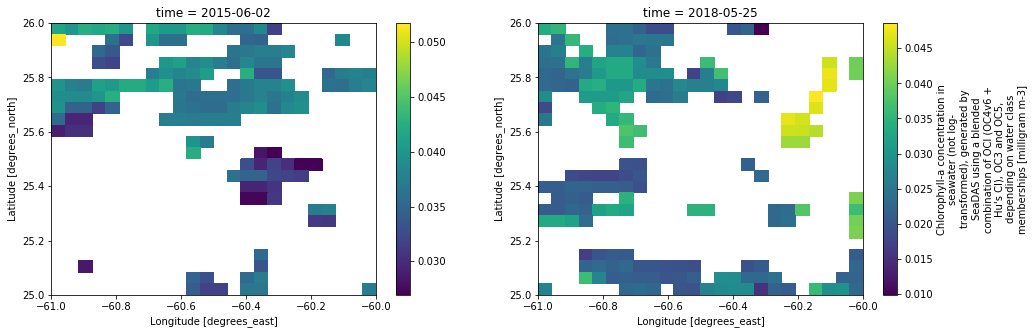

In [14]:
# Note: the color ranges are not the same in the two plots. We didn't try to make them the same. We're just exploring
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))
subset_chlora.isel(time=0).plot(ax=ax1, cbar_kwargs={'label': ''})
subset_chlora.isel(time=-1).plot(ax=ax2);

That's an awfully long colorbar caption!

## Plot as a spatially averaged time series
We'll build on what we learned in the previous notebook.

In [15]:
chlora_xymean = subset_chlora.mean(dim=('latitude', 'longitude'))

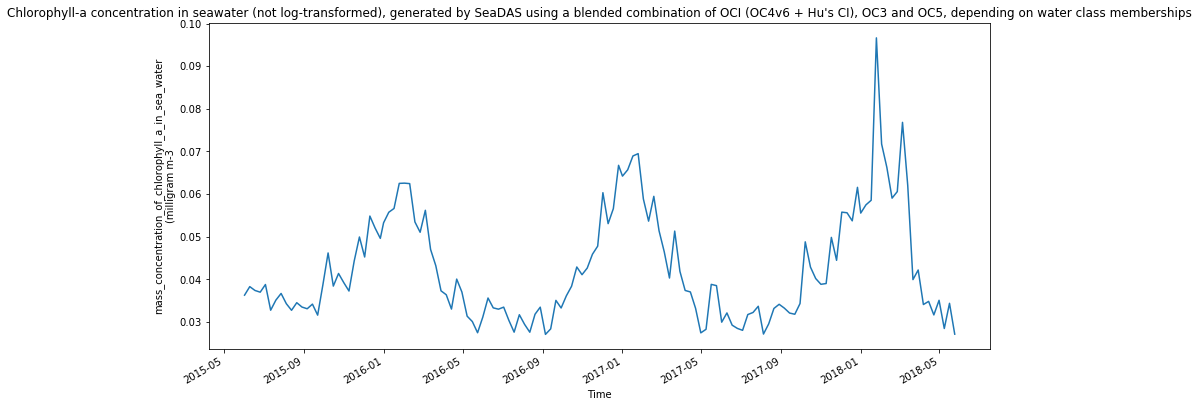

In [16]:
chlora_xymean.plot(figsize=(14,6))
plt.ylabel(f"{subset_chlora.standard_name}\n({subset_chlora.units}")
plt.title(subset_chlora.long_name);

**The period around 2018 Feb-Mar is pretty interesting, compared to previous years!** Let's zoom in a bit.

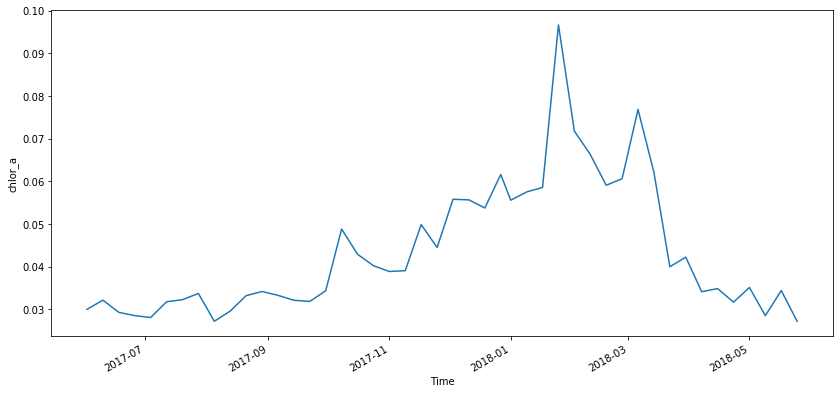

In [17]:
chlora_xymean.sel(time=slice(datetime.datetime(2017,6,1), 
                             datetime.datetime(2018,6,1))
                 ).plot(figsize=(14,6));

# EXERCISE: Query PODAAC OSTIA SST for the same spatial bounding box and temporal range
Get a time series of a couple of months for the same small bounding box, focusing on the interesting chlorophyll peaks in early 2018. **Refer to the PODAAC notebook we just saw.**

## PODAAC utilities to make querying easier and more compact
But this implementation does not reuse podaac objects.

In [18]:
def get_podaac_granuleurls(keyword, start_dt, end_dt, items_per_page='400'):
    import configparser
    from lxml import objectify

    import podaac.podaac as podaac
    # to obtain rich information from PO.DAAC Drive, import and create an instance of Drive
    from podaac import drive as podaacdrive
    
    # for search capabilities import podaacpy, then create an instance of the Podaac class
    p = podaac.Podaac()
    
    with open(BASEPATH / 'podaac.ini', 'r') as f:
        config = configparser.ConfigParser()
        config.read_file(f)
        d = podaacdrive.Drive(None, 
                              config['drive']['urs_username'], 
                              config['drive']['urs_password'])
    
    dresult = p.dataset_search(keyword=keyword, start_time=start_dt, end_time=end_dt)
    dresult_xml = objectify.fromstring(dresult)
    # But note that there can be multiple entry instances, so list handling would be needed, generically
    # The "podaac:datasetId" element would probably be more correct than "id"
    dataset_id = dresult_xml.entry.id.text    
    gresult = p.granule_search(dataset_id=dataset_id, start_time=start_dt, end_time=end_dt,
                               items_per_page=items_per_page)
    # podaacpy provides a convenience function which enables easy access to all Drive urls
    urls = d.mine_drive_urls_from_granule_search(granule_search_response=gresult)
    opendap_urls = [w.replace('-tools.jpl.nasa.gov/drive/files/', '-opendap.jpl.nasa.gov/opendap/') 
                    for w in urls]
    
    return dataset_id, opendap_urls

## Prepare the query and subset parameters

Spatial bounding box slice dictionary. **NOTE: we have to make some changes to the query parameters, relative to the CCI chlorphyll dataset:**
- Use lat and lon instead of latitude and longitude
- Change the latitude slice order, to be in ascending order

In [19]:
ostia_xy_bbox = dict(lat=slice(25,26), lon=slice(-61,-60))

We'll want to be careful with the datetime range, so as not to issue a request for a ton of data; we don't want to wait a long time, or stress the PO.DAAC servers too much.

In [20]:
start_time='2018-01-15T00:00:00Z'
end_time='2018-04-15T23:59:59Z'

In [21]:
podaac_dataset_id, podaac_urls = get_podaac_granuleurls('ostia', start_time, end_time)

In [22]:
print(f"dataset_id: {podaac_dataset_id}. Number of granule urls: {len(podaac_urls)}")

dataset_id: PODAAC-GHOST-4FK02. Number of granule urls: 92


## Now finish the rest